In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
%autoreload
cohort = mre_pinn.data.ImagingCohort(['0006'])
cohort.load_images()
cohort.preprocess()
dataset = cohort.to_dataset()
dataset.save_xarrays('../data/NAFLD3')

In [3]:
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD3', '0006')
example.metadata

Loading ../data/NAFLD3/0006/wave.nc
Loading ../data/NAFLD3/0006/mre.nc
Loading ../data/NAFLD3/0006/mre_mask.nc


size   spacing    origin     limit    center    extent
variable dimension                                                        
wave     x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre      x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre_mask x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000

In [4]:
example.describe()

,,dtype,count,mean,std,min,25%,50%,75%,max
variable,component,,,,,,,,,
wave,scalar,float64,262144.0,0.000139,0.023588,-0.099609,-0.004492,0.0,0.004736,0.099609
mre,scalar,int16,262144.0,1505.871937,1335.735833,0.000000,0.000000,1340.0,2212.000000,14078.000000
mre_mask,scalar,float32,262144.0,0.171467,0.376916,0.000000,0.000000,0.0,0.000000,1.000000


<IPython.core.display.Javascript object>


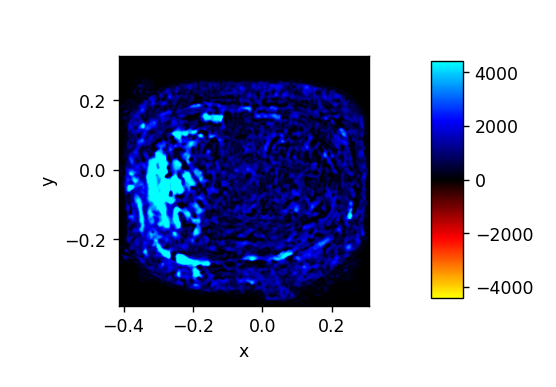

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [5]:
example.eval_baseline(frequency=40, polar=True, postprocess=True)
example.view('base', ax_height=2, ax_width=2)

In [6]:
%autoreload
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=40, detach=True)

In [17]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=60,
    n_layers=5,
    n_hidden=128,
    polar_input=True,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=6, out_features=128, bias=True)
    (hidden1): Linear(in_features=134, out_features=128, bias=True)
    (hidden2): Linear(in_features=262, out_features=128, bias=True)
    (hidden3): Linear(in_features=390, out_features=128, bias=True)
    (output): Linear(in_features=518, out_features=1, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=6, out_features=128, bias=True)
    (hidden1): Linear(in_features=134, out_features=128, bias=True)
    (hidden2): Linear(in_features=262, out_features=128, bias=True)
    (hidden3): Linear(in_features=390, out_features=128, bias=True)
    (output): Linear(in_features=518, out_features=1, bias=True)
  )
)

In [18]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-16],
    pde_warmup_iters=5000,
    pde_step_iters=5000,
    pde_init_weight=1e-18,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000190 s



In [19]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0013s (13.34%)
Model time/iter: 0.0009s (8.89%)
Loss time/iter:  0.0075s (77.77%)
Total time/iter: 0.0096s
Total time: 0.9595s
1k iters time: 0.16m
10k iters time: 1.60m
100k iters time: 0.27h


<IPython.core.display.Javascript object>


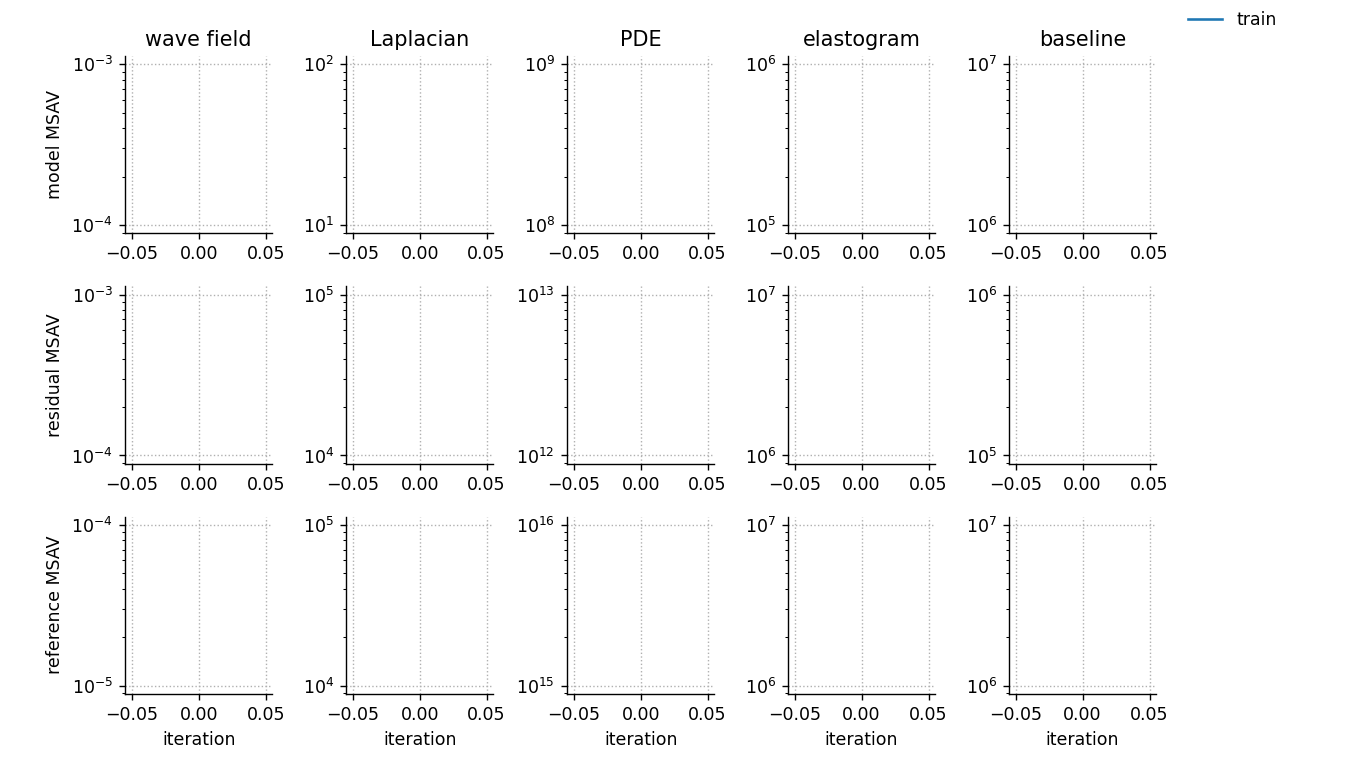

<IPython.core.display.Javascript object>


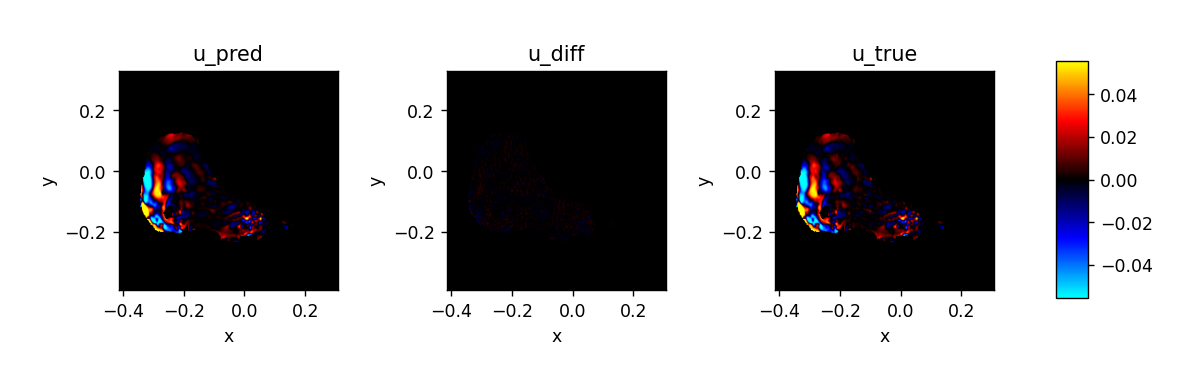

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


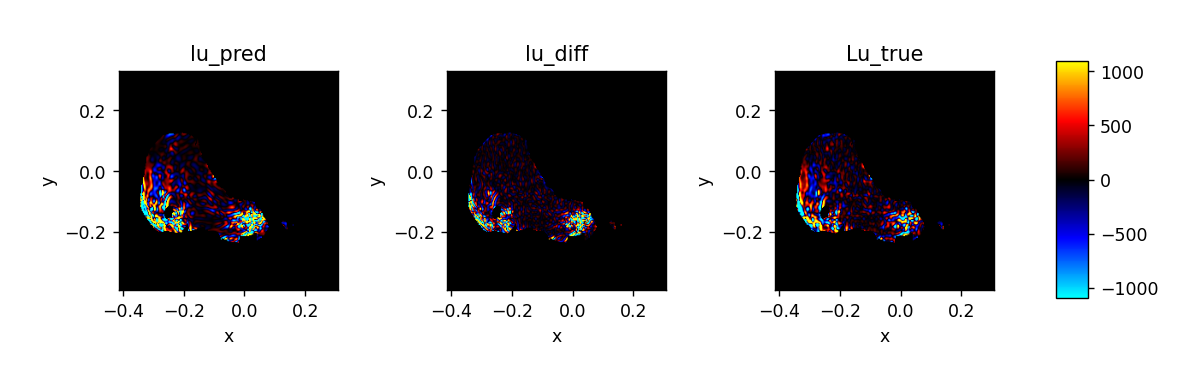

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


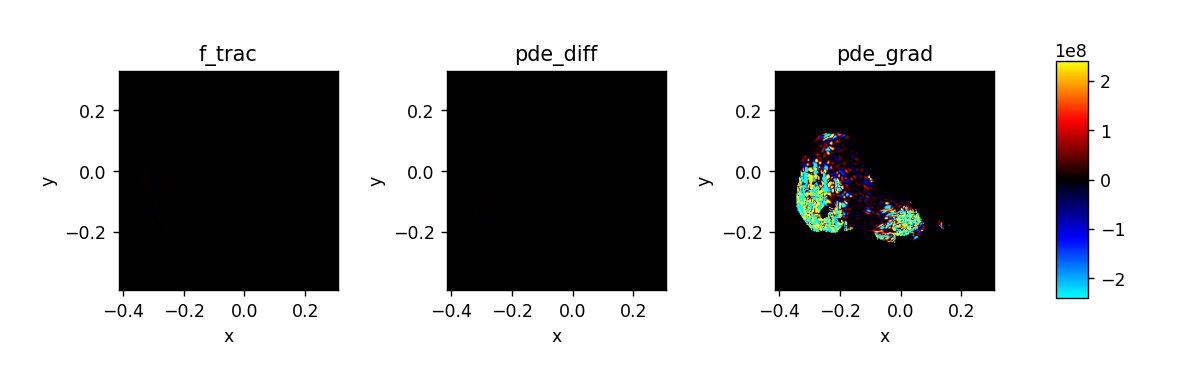

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


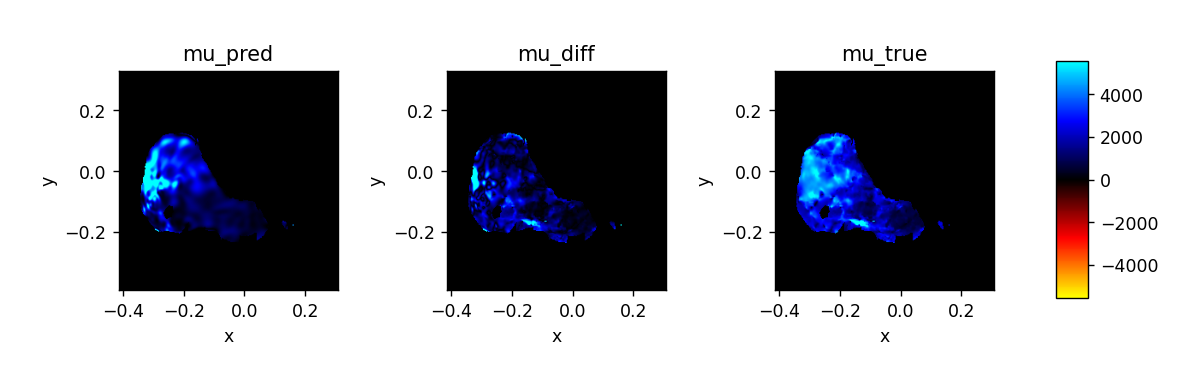

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


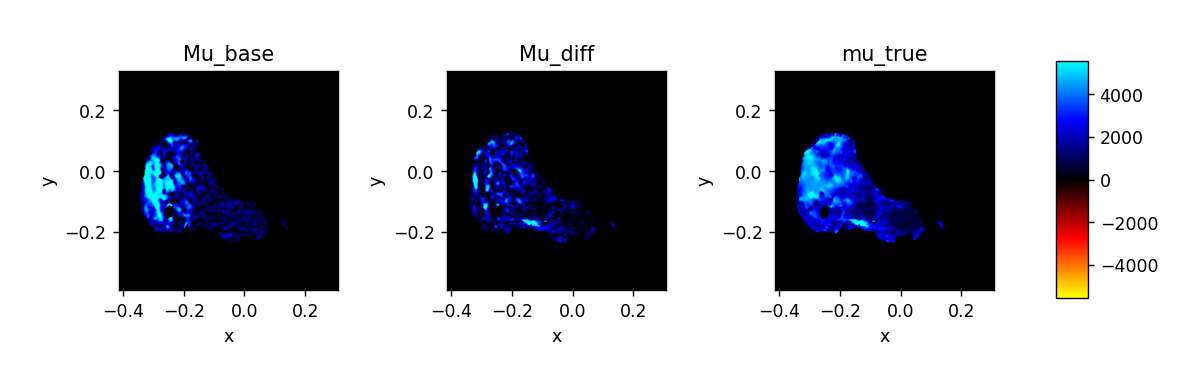

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [20]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

0         [2.24e-03, 0.00e+00, 0.00e+00]    [2.23e-03, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


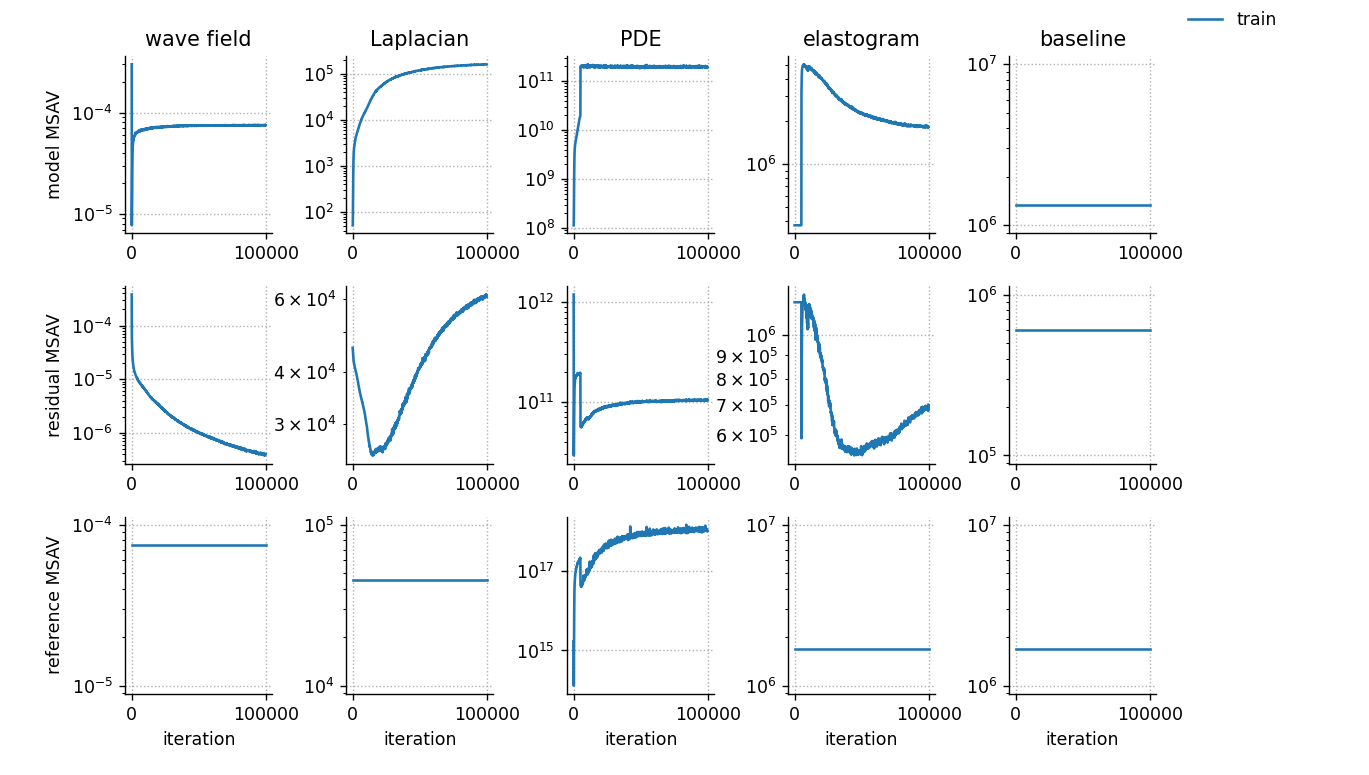

Time spent testing: 16.5694 (49.34%)
Time spent testing: 16.1984 (62.13%)
Time spent testing: 15.1538 (68.78%)
Time spent testing: 15.2113 (68.97%)
Time spent testing: 15.1265 (68.09%)
Time spent testing: 15.5079 (70.82%)
Time spent testing: 16.0608 (71.22%)
Time spent testing: 15.1966 (71.85%)
Time spent testing: 15.7615 (73.47%)
Time spent testing: 15.3995 (73.97%)
1000      [1.21e-04, 0.00e+00, 0.00e+00]    [1.12e-04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 15.2460 (74.61%)
Time spent testing: 15.8210 (74.74%)
Time spent testing: 16.3248 (74.58%)
Time spent testing: 15.2949 (75.44%)
Time spent testing: 15.4015 (76.23%)
Time spent testing: 15.6164 (76.14%)
Time spent testing: 15.2610 (76.76%)
Time spent testing: 16.2195 (76.73%)
Time spent testing: 16.1494 (76.65%)
Time spent testing: 15.1495 (77.28%)
2000      [8.20e-05, 0.00e+00, 0.00e+00]    [8.36e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 15.1355 (77.37%)
Time spent testing: 15.3702 (76.94%)
Time spent testing: 

Time spent testing: 16.6593 (80.85%)
Time spent testing: 15.4553 (80.90%)
Time spent testing: 15.4414 (80.92%)
Time spent testing: 16.2576 (80.86%)
Time spent testing: 22.9112 (80.94%)
Time spent testing: 16.6173 (80.88%)
Time spent testing: 15.6214 (80.92%)
Time spent testing: 15.8921 (80.96%)
19000     [1.72e-05, 0.00e+00, 4.63e-05]    [1.76e-05, 0.00e+00, 4.67e-05]    []  
Time spent testing: 15.5022 (80.94%)
Time spent testing: 15.5772 (80.98%)
Time spent testing: 16.6142 (80.96%)
Time spent testing: 16.7888 (80.93%)
Time spent testing: 15.4822 (80.98%)
Time spent testing: 15.4307 (80.97%)
Time spent testing: 15.7595 (80.89%)
Time spent testing: 16.1632 (80.88%)
Time spent testing: 16.8397 (80.83%)
Time spent testing: 15.9908 (80.87%)
20000     [1.93e-05, 0.00e+00, 4.84e-05]    [1.73e-05, 0.00e+00, 4.66e-05]    []  
Time spent testing: 16.1916 (80.91%)
Time spent testing: 15.8457 (80.91%)
Time spent testing: 15.4653 (80.94%)
Time spent testing: 16.6244 (80.89%)
Time spent testing: 

Time spent testing: 17.0801 (80.58%)
Time spent testing: 16.1415 (80.56%)
Time spent testing: 16.6413 (80.59%)
Time spent testing: 15.8242 (80.59%)
Time spent testing: 16.0965 (80.61%)
Time spent testing: 16.8765 (80.61%)
37000     [8.32e-06, 0.00e+00, 5.30e-05]    [8.37e-06, 0.00e+00, 4.65e-05]    []  
Time spent testing: 17.2316 (80.59%)
Time spent testing: 15.9521 (80.62%)
Time spent testing: 15.8536 (80.63%)
Time spent testing: 16.1947 (80.60%)
Time spent testing: 16.5784 (80.63%)
Time spent testing: 17.0847 (80.60%)
Time spent testing: 16.0939 (80.62%)
Time spent testing: 16.5652 (80.64%)
Time spent testing: 16.0770 (80.65%)
Time spent testing: 16.3445 (80.67%)
38000     [7.56e-06, 0.00e+00, 5.46e-05]    [8.11e-06, 0.00e+00, 4.62e-05]    []  
Time spent testing: 17.1818 (80.65%)
Time spent testing: 17.2274 (80.64%)
Time spent testing: 16.0852 (80.66%)
Time spent testing: 15.9168 (80.68%)
Time spent testing: 16.2348 (80.66%)
Time spent testing: 16.2222 (80.64%)
Time spent testing: 

Time spent testing: 19.4151 (80.17%)
Time spent testing: 16.6310 (80.18%)
Time spent testing: 17.1066 (80.19%)
Time spent testing: 16.4353 (80.20%)
55000     [4.62e-06, 0.00e+00, 6.19e-05]    [4.89e-06, 0.00e+00, 4.59e-05]    []  
Time spent testing: 16.4525 (80.22%)
Time spent testing: 16.2515 (80.18%)
Time spent testing: 16.3701 (80.19%)
Time spent testing: 17.5185 (80.18%)
Time spent testing: 17.8828 (80.17%)
Time spent testing: 17.3200 (80.19%)
Time spent testing: 16.7141 (80.20%)
Time spent testing: 16.4183 (80.21%)
Time spent testing: 16.2794 (80.19%)
Time spent testing: 16.4547 (80.17%)
56000     [5.00e-06, 0.00e+00, 5.43e-05]    [4.53e-06, 0.00e+00, 4.90e-05]    []  
Time spent testing: 16.5729 (80.18%)
Time spent testing: 17.4704 (80.15%)
Time spent testing: 16.9143 (80.17%)
Time spent testing: 17.4702 (80.16%)
Time spent testing: 17.2439 (80.17%)
Time spent testing: 16.7890 (80.19%)
Time spent testing: 16.3907 (80.18%)
Time spent testing: 16.4933 (80.19%)
Time spent testing: 

Time spent testing: 19.1733 (80.82%)
Time spent testing: 18.3065 (80.83%)
73000     [3.26e-06, 0.00e+00, 5.61e-05]    [3.21e-06, 0.00e+00, 4.45e-05]    []  
Time spent testing: 18.4982 (80.85%)
Time spent testing: 18.1323 (80.85%)
Time spent testing: 18.0661 (80.87%)
Time spent testing: 19.0193 (80.86%)
Time spent testing: 17.7564 (80.86%)
Time spent testing: 19.1699 (80.87%)
Time spent testing: 18.1039 (80.88%)
Time spent testing: 18.3853 (80.89%)
Time spent testing: 19.1180 (80.90%)
Time spent testing: 18.9883 (80.90%)
74000     [3.09e-06, 0.00e+00, 5.34e-05]    [3.42e-06, 0.00e+00, 4.30e-05]    []  
Time spent testing: 18.5584 (80.92%)
Time spent testing: 18.3924 (80.91%)
Time spent testing: 19.0302 (80.90%)
Time spent testing: 19.1513 (80.90%)
Time spent testing: 19.0631 (80.90%)
Time spent testing: 18.0450 (80.91%)
Time spent testing: 18.3794 (80.92%)
Time spent testing: 17.7451 (80.92%)
Time spent testing: 18.3430 (80.93%)
Time spent testing: 19.2845 (80.94%)
75000     [2.97e-06,

Time spent testing: 18.2586 (81.61%)
92000     [2.27e-06, 0.00e+00, 5.14e-05]    [2.14e-06, 0.00e+00, 4.42e-05]    []  
Time spent testing: 19.3031 (81.60%)
Time spent testing: 18.4498 (81.61%)
Time spent testing: 18.9178 (81.61%)
Time spent testing: 18.4236 (81.62%)
Time spent testing: 18.6412 (81.63%)
Time spent testing: 18.5966 (81.62%)
Time spent testing: 18.4350 (81.62%)
Time spent testing: 19.1910 (81.62%)
Time spent testing: 18.9654 (81.63%)
Time spent testing: 18.3624 (81.64%)
93000     [2.36e-06, 0.00e+00, 5.81e-05]    [2.40e-06, 0.00e+00, 4.35e-05]    []  
Time spent testing: 18.3344 (81.63%)
Time spent testing: 18.3753 (81.64%)
Time spent testing: 19.2584 (81.64%)
Time spent testing: 18.9822 (81.64%)
Time spent testing: 18.7444 (81.66%)
Time spent testing: 18.3159 (81.65%)
Time spent testing: 18.3833 (81.65%)
Time spent testing: 19.2347 (81.65%)
Time spent testing: 19.3164 (81.65%)
Time spent testing: 18.2708 (81.66%)
94000     [2.37e-06, 0.00e+00, 6.14e-05]    [2.20e-06, 0.

(<deepxde.model.LossHistory at 0x14a8d799ec80>,
 <deepxde.model.TrainState at 0x14a8ccb4e9b0>)

In [21]:
model.train(100000, callbacks=[test_eval])